In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f" The latest date found in the dataset is", recent_date)

 The latest date found in the dataset is ('2017-08-23',)


In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date=dt.datetime(2017, 8, 23)
# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta
last_year=latest_date - timedelta(days=365)
#print(last_year)
# Perform a query to retrieve the data and precipitation scores
#get start of the query date and end of the query date
enddate = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
startdate = dt.date(enddate.year -1, enddate.month, enddate.day)
print(startdate)
end=dt.date(enddate.year,enddate.month, enddate.day)
#end

# Save the query results as a Pandas DataFrame and set the index to the date column
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= startdate).all()
# Sort the dataframe by date

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()



# Use Pandas Plotting with Matplotlib to plot the data




2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


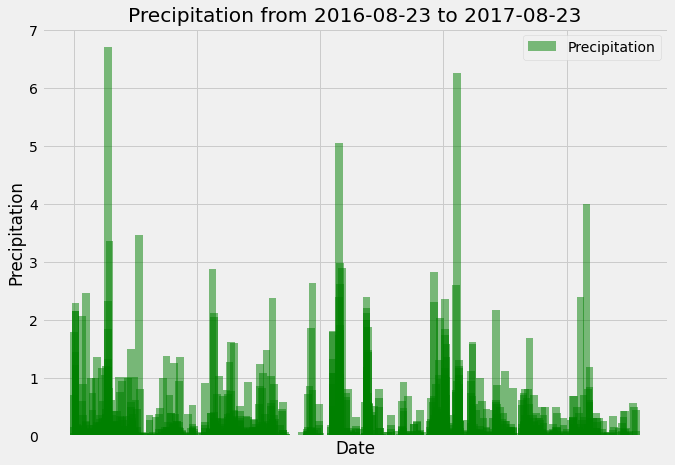

In [29]:

xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='g', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to x-axis
    which='both',      # major and minor ticks affected
    bottom=False,      # bottom edge ticks are off
    top=False,         # top edge ticks are off
    labelbottom=False) # bottom edge labels are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {startdate} to {end}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.savefig(".//Images//prcp.png")
plt.show()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count() # id is the primary key

9

In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = engine.execute('SELECT min(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for lowest in lowest_temp:
    print(f" the lowest temperature was ",lowest)

highest_temp = engine.execute('SELECT max(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for highest in highest_temp:
    print(f" the highest temperature was ", highest)
    
avg_temp = engine.execute('SELECT avg(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for avg in avg_temp:
    print(f" the average temperature was", avg)

 the lowest temperature was  (54.0,)
 the highest temperature was  (85.0,)
 the average temperature was (71.66378066378067,)


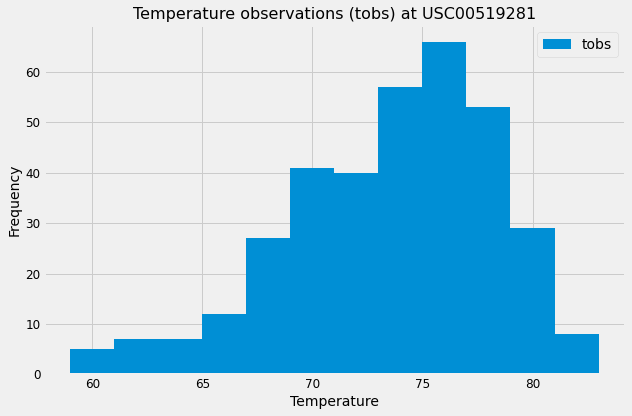

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_active= activestations[0][0]
top_active_tobs = pd.DataFrame(session.query(Measurement.tobs).\
                                filter((Measurement.station == top_active)\
                                        & (Measurement.date >= startdate)\
                                        & (Measurement.date <= end)).all())
                                       

top_active_tobs.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {top_active}", fontsize=16)

plt.tight_layout()
plt.savefig(".//Images//tobs.png")
plt.show()

# Close session

In [36]:
# Close Session
session.close()